<a href="https://colab.research.google.com/github/hamasakram/Developers-Corporation-AI-Internship/blob/main/Unsupervised_Fraud_Detection_Isolation_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
##All General Import Statements
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import os


# Anomaly Detection Algorithms: Isolation Forest vs the Rest

<p>This notebook shows a simplified implementation of the algorithm Isolation Forest and compares its Scikit-learn implementation with other popular anomaly detection algorithms. (KMeans, Local Outlier Factor, One-Class SVM)</p>

<p>In a real world scenario, an unsupervised model is used primarily as a seed to create labelled data unless risk rules based on domain knowledge can be formulated for the problem. For example, if the problem is to identify anomalies in network traffic metrics such as time between logins and distance between origins can be used to formulate a risk rule. Anomalous logins obtained by applying this rule must then be audited to come up with their true labels. On the other hand take the case of identifying the probability of an employee  committing securities fraud. Here the behavioral data that the organization captures is very high dimensional and the relationship between the data points is complex. Hence without indepth domain knowledge, formulating risk rules is difficult.  This combined with issues such as confidentiality makes it very hard to validate these risk rules.</p>

<p>This is where unsupervised learning shines. With very little domain knowledge, a simple unsupervised algorithm can be used to create a list of anomalies which can then be fed into an auditing process which then generates the true labels. Over time when enough data labels are created, the unsupervised problem can be reformulated as a supervised ML problem.</p>

<p>Since this notebook aims to compare various unsupervised algorithms with each other their actual performance needs to be validated. For this I use a labelled dataset. But the algorithms do not see the labels while training. The labels are only used to compare the model predictions to the actual values and to create performance metrics.</p>

## Isolation Forests in Python

The Algorithm has 3 parts:
    1. Forest
    2. Isolation Tree
    3. Evaluation (Path Length)

### Common Classes

The below code defines classes for external and internal nodes

In [10]:
class ExNode:
    def __init__(self,size):
        self.size=size

class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

### Forest

In [11]:
def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=X.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

### Isolation Tree

In [12]:
def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

### Path Length

In [13]:
def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

## Test Run

Let us now test the algorithm on a test dataset.
Source: https://www.kaggle.com/dalpozz/creditcardfraud

In [16]:
df=pd.read_csv("creditcard.csv")
y_true=df['Class']
df_data=df.drop('Class',axis=1)

Next, we create the forest.

In [18]:
sampleSize = 10000
ifor = iForest(df_data.sample(100000, replace=True), 10, sampleSize)  # Forest of 10 trees


Next, we select 1000 random datapoints and get their path lengths. The purpose for this is to plot and see if anomalies actually have shorter path lengths.

In [19]:
posLenLst=[]
negLenLst=[]

for sim in range(1000):
    ind=random.choice(df_data[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(df_data.iloc[ind],tree,0))

    ind=random.choice(df_data[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(df_data.iloc[ind],tree,0))

Finally, we plot the path lengths.

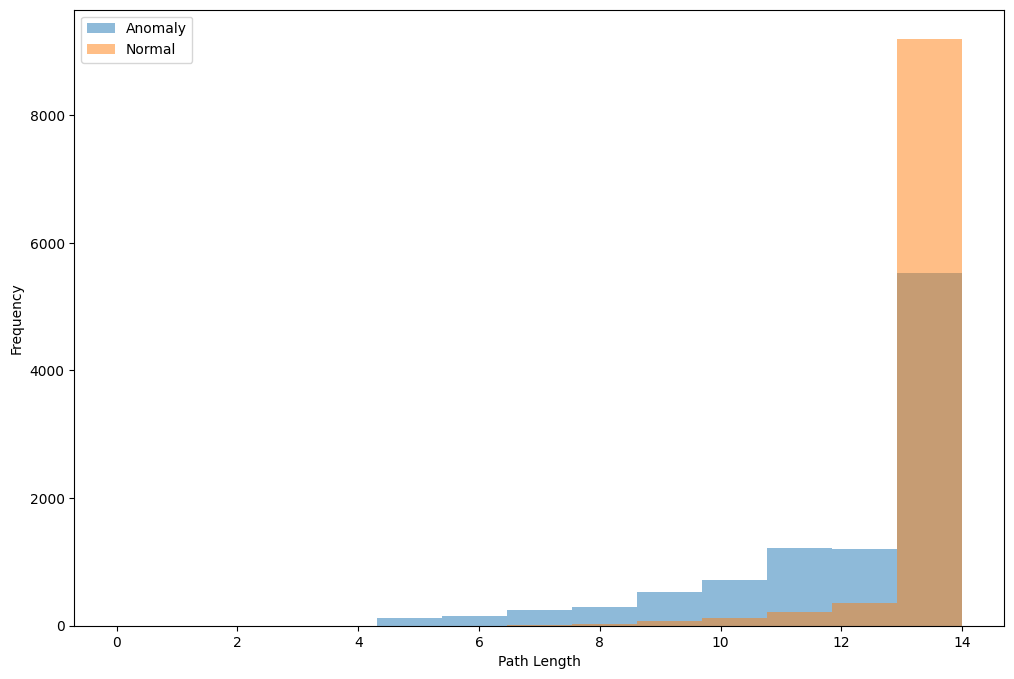

In [20]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

Anomalies do seem to have a lower path length. Not bad for random division!

#### Notes:

The above implementation ignores three aspects of the actual algorithm fo the sake of simplicity.
1. The average depth needs to be added to the depth once the current length hits the height limit
2. The path lengths are not normalized between trees and hence the actual values are used for plotting
3. The authors of the paper suggest using kurtosis to select features as a refinement over random selection

## Plotting the Data

Using a technique called T-SNE, we can reduce the dimensions of the data and create a 2D plot. The objective here is to show that distance based anomaly detection methods might not work as well as other techniques on this dataset. This is because the positive cases are not too far away from the normal cases.

In [21]:
from sklearn.manifold import TSNE

In [24]:
df_plt=df[df['Class']==0].sample(1000)
df_plt_pos=df[df['Class']==1].sample(20)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class',axis=1)

In [25]:
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

<ipython-input-26-639996d80a37>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))


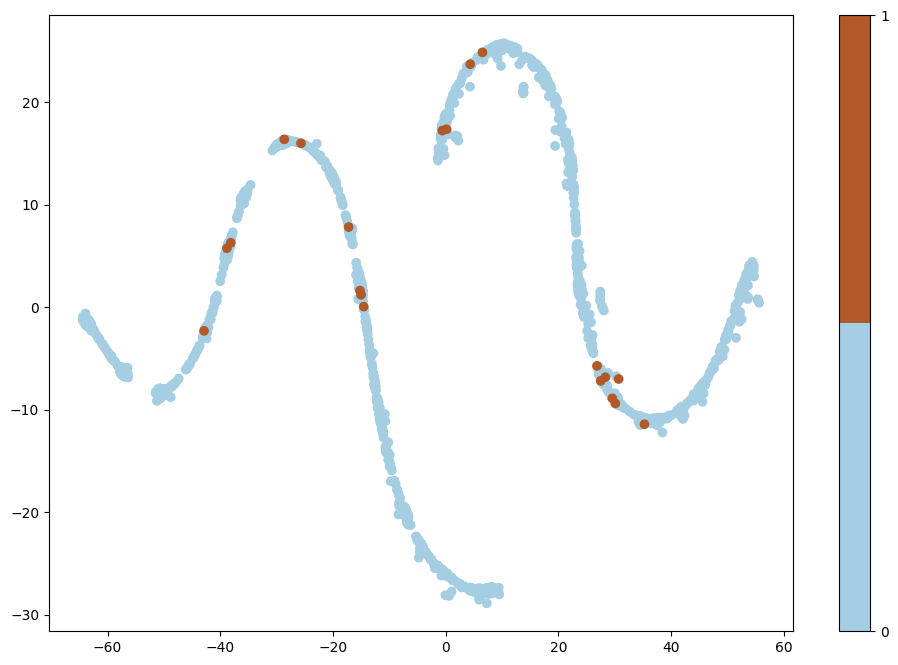

In [26]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

## Time for the Real Fight!

To keep things even, all of the algorithms are run with their default parameters.

Let's start by importing the scikit-learn implementations of all 4 algorithms.

In [27]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans

Next, let's create a train and test dataset.

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.3, random_state=42)

In [30]:
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

In [31]:
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

Finally, let's import some model scoring libraries. Since, we are dealing with a heavily imbalanced dataset, F1 Score is used as a proxy for model performance.

For more details, refer http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

#### Isolation Forest

In [34]:
from sklearn.ensemble import IsolationForest

alg = IsolationForest(n_estimators=100,
                      max_samples='auto',
                      contamination=0.01,
                      max_features=1.0,
                      bootstrap=False,
                      n_jobs=-1,
                      random_state=42,
                      verbose=0)


<b>Note:</b> The magic function timeit does not let us use any variable that is created in the timeit cell. Hence, every cell with a timeit magic function will have a corresponding regular cell with the same code.

In [35]:
%%timeit
if_mdlLst=train(X_train,alg)

2 s ± 729 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
if_mdlLst=train(X_train,alg)

In [37]:
%%timeit
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

497 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [39]:
roc_auc_score(y_test, if_y_pred_class)

0.9263741249675913

In [40]:
f1_score(y_test, if_y_pred_class)

0.10922330097087378

In [41]:
if_cm=confusion_matrix(y_test, if_y_pred_class)

<Axes: >

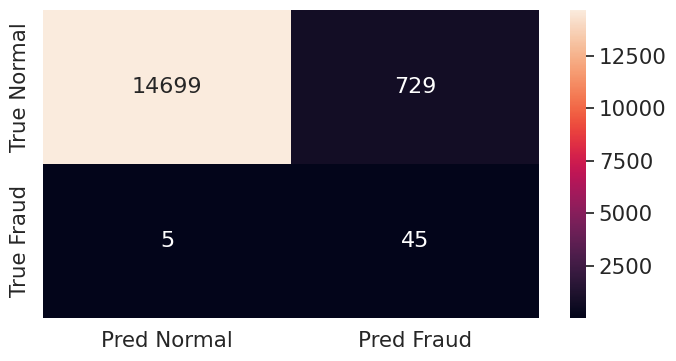

In [42]:
import seaborn as sn

df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

## Conclusion

Coming to model performance, our isolation forest ensemble model is a clear winner!